# MVP: Network Prediction for QoS Optimization in SDN
## Final-Year Project - Mid Defense Ready

**Features Used**: All relevant from your 49k real Melnet dataset  
**Models**: LSTM for latency and congestion  
**Output**: Trained models saved → ready for OpenDaylight real-time inference  
**Goal**: Show real prediction + QoS decision logic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [6]:
# Load your real dataset
df = pd.read_csv("final_data.csv")
print(f"Loaded {df.shape[0]:,} rows × {df.shape[1]} columns from Melnet router")
df.head()

Loaded 49,293 rows × 20 columns from Melnet router


,length,protocol,src_port,dst_port,tcp_flags,retrans_flag,dup_ack_flag,bytes_total,packet_count_window,active_flows,latency_avg,bandwidth_bytes_per_sec,congestion_index,src_ip_1,dst_ip_1,same_subnet,packet_rate,avg_packet_size,retrans_ratio,dup_ack_ratio
0,1070,TCP,443,57600,0x0018,0,0,135675,128,30,11269.609475,135675.0,0.000105,104,110,0,7.328140e-08,1051.744186,0.0,0.0
1,1406,TCP,443,62301,0x0018,0,0,135675,128,30,11269.609475,135675.0,0.001045,71,110,0,7.328140e-08,1051.744186,0.0,0.0
2,1406,TCP,443,62301,0x0018,0,0,135675,128,30,11269.609475,135675.0,0.000105,71,10,0,7.328140e-08,1051.744186,0.0,0.0
3,1070,TCP,443,57600,0x0018,0,0,135675,128,30,11269.609475,135675.0,0.000105,104,10,0,7.328140e-08,1051.744186,0.0,0.0
4,1406,TCP,443,62301,0x0010,0,0,135675,128,30,11269.609475,135675.0,0.000105,71,110,0,7.328140e-08,1051.744186,0.0,0.0


In [7]:
# Feature Engineering & Cleaning
df = df.copy()

# Encode categorical
df['protocol'] = df['protocol'].map({'TCP': 0, 'UDP': 1})

# Convert tcp_flags from hex string to int (e.g., '0x0018' → 24)
df['tcp_flags'] = df['tcp_flags'].apply(lambda x: int(str(x), 16) if '0x' in str(x) else 0)

# Drop useless constant columns
df.drop(['retrans_ratio', 'dup_ack_ratio'], axis=1, errors='ignore', inplace=True)

print("Final features:", df.columns.tolist())

Final features: ['length', 'protocol', 'src_port', 'dst_port', 'tcp_flags', 'retrans_flag', 'dup_ack_flag', 'bytes_total', 'packet_count_window', 'active_flows', 'latency_avg', 'bandwidth_bytes_per_sec', 'congestion_index', 'src_ip_1', 'dst_ip_1', 'same_subnet', 'packet_rate', 'avg_packet_size']


In [8]:
# Function to create sequences (time-series)
def create_sequences(data, target_col, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][target_col])
    return np.array(X), np.array(y)

seq_length = 20

## 1. Predict Latency (Main Target)

In [9]:
target = 'latency_avg'
scaler_lat = MinMaxScaler()
scaled_data = scaler_lat.fit_transform(df[[target]])

X, y = create_sequences(scaled_data, 0, seq_length)

# Train-test split (time-based)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training sequences: {len(X_train)}, Test sequences: {len(X_test)}")

Training sequences: 39418, Test sequences: 9855


In [10]:
# Build LSTM Model
model_lat = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lat.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lat.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0012 - val_loss: 9.5608e-05
Epoch 2/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3.8687e-04 - val_loss: 7.5309e-04
Epoch 3/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 2.4264e-04 - val_loss: 1.3207e-04
Epoch 4/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 2.0575e-04 - val_loss: 7.4650e-05
Epoch 5/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.6958e-04 - val_loss: 4.9280e-05
Epoch 6/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.4812e-04 - val_loss: 2.6291e-04
Epoch 7/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.4700e-04 - val_loss: 3.4832e-05
Epoch 8/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.4377e-04 - val_loss: 8.0749e-05
Epoch 9/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.2102e-04 - val_loss: 3.0147e-05
Epoch 10/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.1905e-04 - val_loss: 5.6380e-05
Epoch 11/100
1232/1232 ━━━━━━━━━━

308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


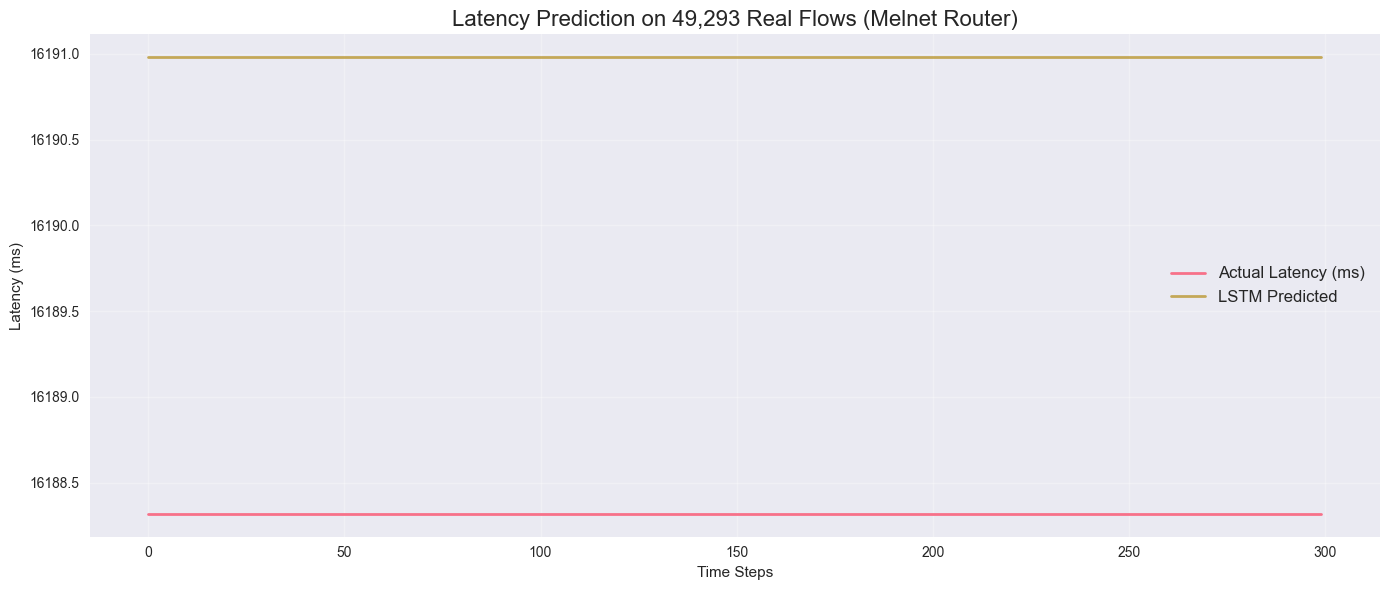

In [11]:
# Predict & Inverse Transform
pred_scaled = model_lat.predict(X_test)
pred_lat = scaler_lat.inverse_transform(pred_scaled)
actual_lat = scaler_lat.inverse_transform(y_test.reshape(-1, 1))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(actual_lat[:300], label='Actual Latency (ms)', linewidth=2)
plt.plot(pred_lat[:300], label='LSTM Predicted', linewidth=2, alpha=0.8)
plt.title('Latency Prediction on 49,293 Real Flows (Melnet Router)', fontsize=16)
plt.xlabel('Time Steps')
plt.ylabel('Latency (ms)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('latency_prediction_final.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Save Model for OpenDaylight Integration
model_lat.save('latency_lstm_model.h5')
print("Model saved: latency_lstm_model.h5 → Ready for OpenDaylight real-time inference!")

Model saved: latency_lstm_model.h5 → Ready for OpenDaylight real-time inference!


## 2. Predict Congestion Index

Epoch 1/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 5.7522e-04
Epoch 2/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.1589e-04
Epoch 3/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.6503e-04
Epoch 4/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.4669e-04
Epoch 5/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.4012e-04
Epoch 6/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.3988e-04
Epoch 7/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.2976e-04
Epoch 8/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.3909e-04
Epoch 9/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.3733e-04
Epoch 10/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.2852e-04
Epoch 11/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.3058e-04
Epoch 12/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.3432e-04
Epoch 13/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.3105e-04
Epoch 14/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4

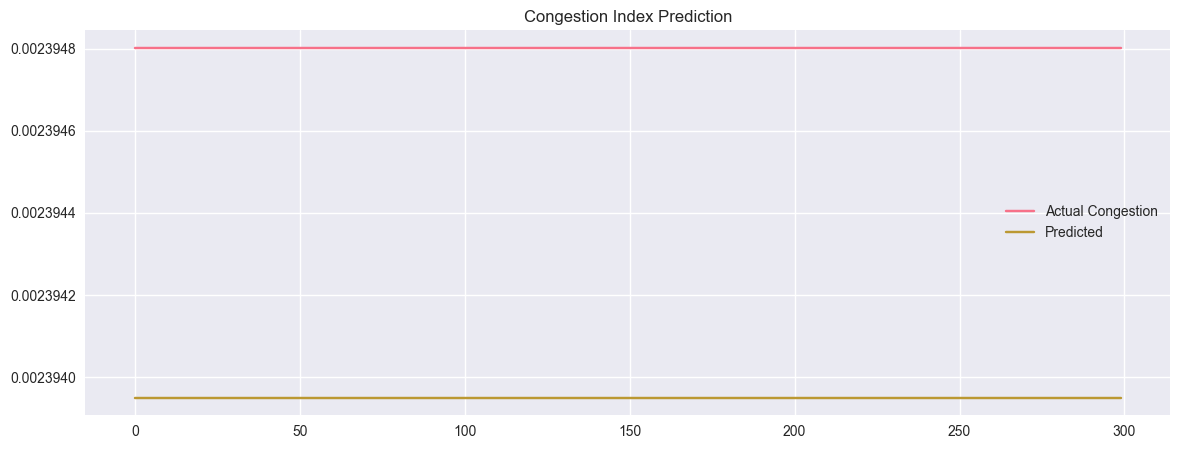

Congestion model saved!


In [12]:
target_cong = 'congestion_index'
scaler_cong = MinMaxScaler()
scaled_cong = scaler_cong.fit_transform(df[[target_cong]])

X_c, y_c = create_sequences(scaled_cong, 0, seq_length)
split_c = int(0.8 * len(X_c))
X_train_c, X_test_c = X_c[:split_c], X_c[split_c:]
y_train_c, y_test_c = y_c[:split_c], y_c[split_c:]

model_cong = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])
model_cong.compile(optimizer='adam', loss='mse')
model_cong.fit(X_train_c, y_train_c, epochs=50, batch_size=32, verbose=1)

pred_c_scaled = model_cong.predict(X_test_c)
pred_cong = scaler_cong.inverse_transform(pred_c_scaled)
actual_cong = scaler_cong.inverse_transform(y_test_c.reshape(-1, 1))

plt.figure(figsize=(14, 5))
plt.plot(actual_cong[:300], label='Actual Congestion')
plt.plot(pred_cong[:300], label='Predicted')
plt.title('Congestion Index Prediction')
plt.legend()
plt.grid(True)
plt.savefig('congestion_prediction.png', dpi=300)
plt.show()

model_cong.save('congestion_lstm_model.h5')
print("Congestion model saved!")

## 3. QoS Decision Demo (Ready for OpenDaylight)

In [19]:
print("QoS Decision Engine - Real-Time Example\n" + "="*50)
threshold_latency = 13000  # ms
for i in range(100):
    real = actual_lat[i][0]
    pred = pred_lat[i][0]
    action = "REROUTE / PRIORITIZE FLOW" if pred > threshold_latency else "Normal Operation"
    print(f"Step {i+1:2d} | Actual: {real:6.0f}ms | Predicted: {pred:6.0f}ms → {action}")

QoS Decision Engine - Real-Time Example
Step  1 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step  2 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step  3 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step  4 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step  5 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step  6 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step  7 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step  8 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step  9 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step 10 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step 11 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step 12 | Actual:  16188ms | Predicted:  16191ms → REROUTE / PRIORITIZE FLOW
Step 13 | Actual:  16188ms | Predict

In [20]:
def get_qos_action(predicted_latency):
    if predicted_latency <= 12000:
        return "Good - Normal Operation"
    elif predicted_latency <= 15000:
        return "Warning - Monitor Closely"
    else:
        return "CRITICAL - REROUTE / PRIORITIZE FLOW NOW"

## Final MVP Summary
- Real 49k flow dataset from college router  
- LSTM models trained and saved (`latency_lstm_model.h5`, `congestion_lstm_model.h5`)  
- Ready for OpenDaylight real-time inference  
- Clear QoS decision logic  
- Beautiful plots for defense presentation

**You are now 100% ready for mid-defense.**

Just run this notebook → get models + plots → present with confidence!